## Libraries

In [1]:
from copy import copy
import numpy as np 
from numpy import exp, log
import pandas as pd 
import os

import tensorflow as tf
import keras
from keras.layers import Embedding, Dense, Concatenate, Flatten, Input, Reshape, AdditiveAttention, LSTM, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)


pd.set_option('display.max_colwidth', -1)

# Simulation Data

### Simulate inputs for 3 channels, constant 2 time steps, 100K observations

In [2]:
channels = ['facebook', 'google', 'snapchat']
num_chnls = len(channels)
N = 100000

np.random.seed(498)
df = pd.DataFrame({'t1':np.random.uniform(-.5,num_chnls-.5,N)
                   , 't2':np.random.uniform(-.5,num_chnls-.5,N)
                   , 't3':np.random.uniform(-.5,num_chnls-.5,N)})

df['t1'] = df['t1'].apply(lambda x: int(round(x)))
df['t2'] = df['t2'].apply(lambda x: int(round(x)))
df['t3'] = df['t3'].apply(lambda x: int(round(x)))

#np.random.seed(1)
df['gap1'] = np.random.gamma(1.2, 1.2, N)
#np.random.seed(2)
df['gap2'] = np.random.gamma(1.2, 1.2, N)
df['gap1'] = df['gap1'] + df['gap2']
#np.random.seed(3)
df['gender'] = np.random.binomial(1, .4, N)


(array([684., 142.,  87.,  40.,  17.,  13.,   5.,   6.,   3.,   3.]),
 array([6.62376023e-08, 2.34107815e-01, 4.68215563e-01, 7.02323311e-01,
        9.36431060e-01, 1.17053881e+00, 1.40464656e+00, 1.63875430e+00,
        1.87286205e+00, 2.10696980e+00, 2.34107755e+00]),
 <a list of 10 Patch objects>)

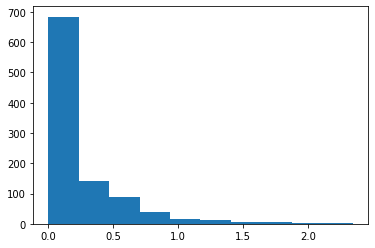

In [3]:
plt.hist(np.random.gamma(.5, .5, 1000))

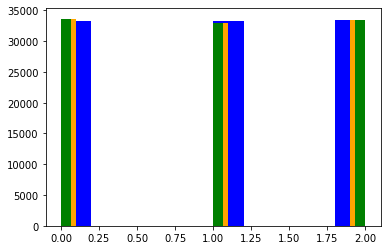

In [4]:
_=plt.hist(df['t1'], bins=10, color='blue')
_=plt.hist(df['t2'], bins=20, color='orange')
_=plt.hist(df['t2'], bins=30, color='green')

### Parameter Assignment

In [5]:

v0 = -3 #intercept, negative since most people don't convert
beta_g0 = 1.7 #google effect when it is first time step is stronger than otherwise
beta_g1 = .8 #google effect when it is second time step
beta_f0 = .9 #facebook effect when it is first time step 
beta_f1 = 1.5 #facebook effect when it is second time step
beta_s0 = .7 #snapchat effect when it is first time step
beta_s1 = .5 #snapchat effect when it is first time step
beta_last_tch = 1 #effect boosted when channel is last touched, constant for all channels
beta_gender = .4 #effect for gender 
alpha = -1.2 #decay effect for gap between time steps, constant for all channels
c = 1 #constant to prevent exploding gap terms when they are <1

#Error term
#np.random.seed(654)
epsilon = np.random.normal(0, 1, len(df))

In [6]:

v0 = -abs(np.random.normal(3, .5, 1))[0] #intercept, negative since most people don't convert
beta_g0 = abs(np.random.normal(1, .3, 1))[0] #google effect when it is first time step is stronger than otherwise
beta_g1 = abs(np.random.normal(.8, .3, 1))[0] #google effect when it is second time step
beta_f0 = abs(np.random.normal(.8, .4, 1))[0] #facebook effect when it is first time step 
beta_f1 = abs(np.random.normal(.8, .4, 1))[0] #facebook effect when it is second time step
beta_s0 = abs(np.random.normal(.6, .3, 1))[0] #snapchat effect when it is first time step
beta_s1 = abs(np.random.normal(1, .3, 1))[0] #snapchat effect when it is first time step
beta_last_tch = abs(np.random.normal(1, .1, 1))[0] #effect boosted when channel is last touched, constant for all channels
beta_gender = abs(np.random.normal(.5, .2, 1))[0] #effect for gender 
alpha = -abs(np.random.normal(1, 1, 1))[0] #decay effect for gap between time steps, constant for all channels
c = 1 #constant to prevent exploding gap terms when they are <1

#Error term
#np.random.seed(654)
epsilon = np.random.normal(0, 1, len(df))


### Logistic Data Generating Function

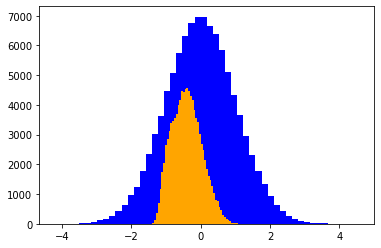

In [7]:

y = v0 + beta_f0*(df['t1']==0)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t2']==0)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t3']==0)*beta_last_tch +\
beta_g0*(df['t1']==1)*df['gap1'].apply(lambda x: (x+c)**alpha) +  beta_g1*(df['t2']==1)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_g1*(df['t3']==1) +\
beta_s0*(df['t1']==2)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t2']==2)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t3']==2)*beta_last_tch +\
beta_gender*df['gender']

plt.hist(epsilon, bins=50, color='blue')
plt.hist(y, bins=50, color='orange')

y = y+epsilon

z = 1/(1+exp(-y))

In [8]:
df['y'] = y 
df['z'] = z 
df['epsilon'] = epsilon

# Conversion for only top 10% of users 
df['conversion'] = df['z']>=np.quantile(df['z'], .9)
df['conversion']= df['conversion'].astype(int)


#### Distribution of P(conversion) and **conversion**

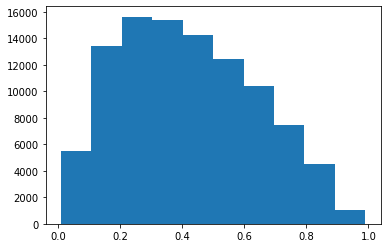

In [9]:
_=plt.hist(df['z'])


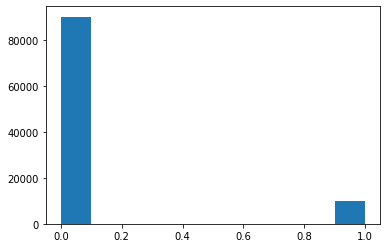

In [10]:
_=plt.hist(df['conversion'])


#### Create columns for the calculated contribution of each channel

In [11]:

df['cont_unscaled_fb'] = beta_f0*(df['t1']==0)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t2']==0)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t3']==0)*beta_last_tch 

df['cont_unscaled_gg'] = beta_g0*(df['t1']==1)*df['gap1'].apply(lambda x: (x+c)**alpha) +  beta_g1*(df['t2']==1)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_g1*(df['t3']==1) 
    
df['cont_unscaled_sp'] = beta_s0*(df['t1']==2)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t2']==2)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t3']==2)*beta_last_tch 


df['cont_fb'] = df['cont_unscaled_fb']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])
df['cont_gg'] = df['cont_unscaled_gg']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])
df['cont_sp'] = df['cont_unscaled_sp']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])


#### View of sample of the dataframe

In [12]:
df[['t1', 't2', 't3', 'gap1',  'gap2', 'gender','y','z','epsilon', 'conversion', 'cont_unscaled_fb','cont_unscaled_gg','cont_unscaled_sp', 'cont_fb', 'cont_gg', 'cont_sp']].sample(10)


,t1,t2,t3,gap1,gap2,gender,y,z,epsilon,conversion,cont_unscaled_fb,cont_unscaled_gg,cont_unscaled_sp,cont_fb,cont_gg,cont_sp
46446,0,1,1,2.991232,1.839293,1,-0.763442,0.317899,-0.546641,0,0.191433,1.702682,0.000000,0.101067,0.898933,0.000000
9347,0,1,1,3.104490,0.785314,0,-0.513991,0.374258,-0.058407,0,0.186173,1.963965,0.000000,0.086587,0.913413,0.000000
95799,0,1,0,1.721027,1.081446,0,0.198510,0.549465,0.754827,0,1.443256,0.606149,0.000000,0.704232,0.295768,0.000000
89721,2,1,1,0.911207,0.675142,0,0.834773,0.697363,1.129059,0,0.000000,2.010209,0.301227,0.000000,0.869680,0.130320
23656,2,0,2,2.952720,2.472946,1,-2.440701,0.080121,-1.903746,0,0.348237,0.000000,1.225725,0.221249,0.000000,0.778751
44667,0,2,0,1.987761,1.745051,0,-0.629229,0.347685,0.149550,0,1.418330,0.000000,0.408613,0.776341,0.000000,0.223659
98822,1,2,1,1.919647,1.667138,0,-0.605034,0.353193,0.022298,0,0.000000,1.557893,0.420498,0.000000,0.787455,0.212545
84398,2,2,1,3.143899,3.121115,1,-2.116213,0.107531,-1.675065,0,0.000000,1.257735,0.412034,0.000000,0.753239,0.246761
29884,0,0,0,1.784579,1.669253,0,-0.766887,0.317153,-0.050631,0,1.889466,0.000000,0.000000,1.000000,0.000000,0.000000
30239,0,0,2,2.038157,0.274497,1,1.242039,0.775919,1.077247,1,1.196083,0.000000,1.079625,0.525587,0.000000,0.474413


#### Distribution of epsilon for conversion==1
###### P(epsilon | conversion=1) has a higher mean than P(epsilon | conversion=0), as expected

(array([8.500e+01, 8.490e+02, 2.456e+03, 3.329e+03, 2.173e+03, 8.220e+02,
        2.190e+02, 5.300e+01, 1.300e+01, 1.000e+00]),
 array([-0.01297214,  0.44480754,  0.90258722,  1.3603669 ,  1.81814658,
         2.27592626,  2.73370594,  3.19148562,  3.6492653 ,  4.10704498,
         4.56482466]),
 <a list of 10 Patch objects>)

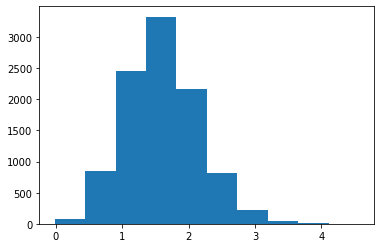

In [13]:
plt.hist(df[df['conversion']==1]['epsilon'])

#### Distribution of epsilon for conversion==0
###### P(epsilon | conversion=0) has a lower mean than P(epsilon | conversion=1), as expected

(array([1.2000e+01, 1.6100e+02, 9.7400e+02, 3.9680e+03, 1.1196e+04,
        2.0196e+04, 2.5109e+04, 2.0031e+04, 7.5600e+03, 7.9300e+02]),
 array([-4.21087428, -3.56647999, -2.92208571, -2.27769142, -1.63329713,
        -0.98890284, -0.34450855,  0.29988574,  0.94428003,  1.58867431,
         2.2330686 ]),
 <a list of 10 Patch objects>)

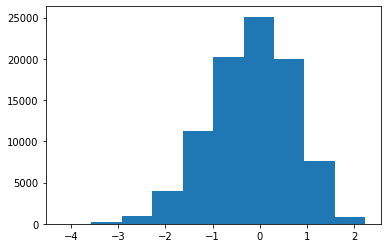

In [14]:
plt.hist(df[df['conversion']==0]['epsilon'])

## Format Data for Input

In [15]:
num_time_steps = 3
num_cats = 3
num_feats = 2

### Train Test Split / Split into Numerical and Categorical Matrices / Reshape 

In [16]:
df['gap3'] = 0 #create an extra gap column for time step 2 which is always 0 since there is no time step 3 in this simulation
df['gender_t2'] = df['gender'] #create an extra gender column for time step 2 which is the same as gender
df['gender_t3'] = df['gender'] #create an extra gender column for time step 2 which is the same as gender
df['log_gap1'] = log(df['gap1'])
df['log_gap2'] = log(df['gap2'])
df['log_gap3'] = 0

X = df[['t1', 't2','t3','gender', 'gap1','log_gap1', 'gender_t2', 'gap2','log_gap2', 'gender_t3', 'gap3','log_gap3', 'epsilon']]
y = np.array(df['conversion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

#Split X_train into numerical and categorical matrices for separate input into the model
#X_train_num = np.array(X_train[['gender', 'gap1','log_gap1', 'gender_t2','gap2', 'log_gap2', 'gender_t3','gap3', 'log_gap3']]) #gender is time-invariant so the same for both time steps
#X_test_num = np.array(X_test[['gender', 'gap1','log_gap1', 'gender_t2','gap2', 'log_gap2', 'gender_t3','gap3', 'log_gap3']])
X_train_num = np.array(X_train[['gender','log_gap1', 'gender_t2', 'log_gap2', 'gender_t3', 'log_gap3']]) #gender is time-invariant so the same for both time steps
X_test_num = np.array(X_test[['gender','log_gap1', 'gender_t2', 'log_gap2', 'gender_t3', 'log_gap3']])

X_train_num2 = np.reshape(X_train_num, (len(X_train_num),num_time_steps, num_feats))
X_test_num2 = np.reshape(X_test_num, (len(X_test_num),num_time_steps, num_feats))
X_train_cat = X_train[['t1', 't2', 't3']]
X_train_cat2 = np.reshape(np.array(X_train_cat), (len(X_train_cat),num_time_steps , 1))
X_test_cat = X_test[['t1', 't2', 't3']]
X_test_cat2 = np.reshape(np.array(X_test_cat), (len(X_test_cat), num_time_steps , 1))
print(X_train_cat2.shape)
print(X_train_num2.shape)
print(X_test_cat2.shape)
print(X_test_num2.shape)
print(y_train.shape)
print(y_test.shape)


(70000, 3, 1)
(70000, 3, 2)
(30000, 3, 1)
(30000, 3, 2)
(70000,)
(30000,)


#### View sample of X_train_num2 

In [17]:
X_train_num2[:3]

array([[[ 1.        ,  1.8372666 ],
        [ 1.        ,  1.14110961],
        [ 1.        ,  0.        ]],

       [[ 0.        , -0.40026814],
        [ 0.        , -0.43297568],
        [ 0.        ,  0.        ]],

       [[ 0.        , -0.42064621],
        [ 0.        , -1.20213539],
        [ 0.        ,  0.        ]]])

#### Verify X_train_cat2 is tokenized

In [18]:
df

,t1,t2,t3,gap1,gap2,gender,y,z,epsilon,conversion,...,cont_unscaled_sp,cont_fb,cont_gg,cont_sp,gap3,gender_t2,gender_t3,log_gap1,log_gap2,log_gap3
0,0,2,0,2.190819,1.523924,0,-1.347063,0.206351,-0.587738,0,...,0.444254,0.759394,0.000000,0.240606,0,0,0,0.784275,0.421289,0
1,0,0,0,1.637772,1.363923,0,-1.116748,0.246615,-0.473866,0,...,0.000000,1.000000,0.000000,0.000000,0,0,0,0.493337,0.310365,0
2,1,2,1,3.548731,3.432864,0,-1.383536,0.200442,-0.482122,0,...,0.253551,0.000000,0.851230,0.148770,0,0,0,1.266590,1.233395,0
3,2,0,0,2.072739,1.611280,0,-1.119193,0.246161,-0.326713,0,...,0.187739,0.896462,0.000000,0.103538,0,0,0,0.728871,0.477029,0
4,1,2,1,4.812273,0.483884,0,-0.284701,0.429302,0.158147,0,...,0.753920,0.000000,0.651427,0.348573,0,0,0,1.571170,-0.725911,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,2,2,0.917585,0.207132,0,0.364842,0.590212,0.664756,0,...,2.305808,0.000000,0.000000,1.000000,0,0,0,-0.086010,-1.574401,0
99996,2,1,2,8.081462,2.881253,0,-0.878283,0.293534,0.258067,0,...,1.143441,0.000000,0.221816,0.778184,0,0,0,2.089573,1.058225,0
99997,0,1,0,6.574965,5.842555,0,-0.583685,0.358085,0.572657,0,...,0.000000,0.872137,0.127863,0.000000,0,0,0,1.883269,1.765168,0
99998,0,2,2,2.204649,1.621151,1,-0.008375,0.497906,0.356875,0,...,1.507469,0.136451,0.000000,0.863549,0,1,1,0.790568,0.483136,0


In [19]:
X_train_cat2[:3]

array([[[0],
        [1],
        [2]],

       [[1],
        [2],
        [2]],

       [[0],
        [2],
        [2]]])

## Deep Learning Model Construction

In [20]:
embedding_size = 20 #dimensionality of embedding vector
cardinality = num_chnls # cardinality of the categorical feature (channel)
lstm_size = 256

In [21]:
from keras import backend as K

class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.w=self.add_weight(shape=(lstm_size, units), initializer="normal")
        self.b=self.add_weight(shape=(3, units), initializer="zeros")
        
        #self.w2=self.add_weight(shape=(units, 1), initializer="normal")
        #self.b2=self.add_weight(shape=(2, 1), initializer="zeros")

    def call(self, x, return_sequences=True):

        e1 = K.relu(K.dot(x,self.w)+self.b)
        
        #print(e1)
        #e2 = K.relu(K.dot(e1,self.w2)+self.b2)
        #print(e2)
        a = K.softmax(e1, axis=1)
        
        #a = tf.keras.activations.softmax(e1, axis=1)
 
        output = a*x
        return e1, K.sum(output, axis=1)

In [22]:


inp_cat_data = Input(shape=(num_time_steps, 1)) #input for categorical data
inp_num_data = Input(shape=(num_time_steps, num_feats)) #input for numerical data

emb = Embedding(cardinality, embedding_size, input_length=(num_time_steps))(inp_cat_data) #Embedding layer for categorical data (channels)

resh1 = Reshape((num_time_steps, embedding_size))(emb) #reshape to squash the 4D tensor back into 3D, not sure why emb layer does this

conc = Concatenate()([resh1, inp_num_data]) #combine numerical data with channel embedding tensor before inputting into LSTM

resh2 = Reshape((num_time_steps, embedding_size+num_feats))(conc) #reshape to fit LSTM needs just in case
# LSTM with channel embeddings and control features, returns hidden state sequences for the attention layer to use
lstm_layer1 = LSTM(lstm_size, dropout=.01, recurrent_dropout=.01,return_sequences=True)(resh2)
lstm_layer2 = LSTM(lstm_size, dropout=.01, recurrent_dropout=.01,return_sequences=True)(lstm_layer1)
lstm_layer3 = LSTM(lstm_size, dropout=.01, recurrent_dropout=.01,return_sequences=True)(lstm_layer2)
lstm_layer4 = LSTM(256, dropout=.01, recurrent_dropout=.01,return_sequences=True)(lstm_layer3)
#lstm_layer5 = LSTM(lstm_size, dropout=.01, recurrent_dropout=.01,return_sequences=True)(lstm_layer4)
#lstm_layer6 = LSTM(lstm_size, dropout=.01, recurrent_dropout=.01,return_sequences=True)(lstm_layer5)
#lstm_layer7 = LSTM(lstm_size, dropout=.01, recurrent_dropout=.01,return_sequences=True)(lstm_layer6)

#lstm_layer = Bidirectional(LSTM(128, dropout=.01, recurrent_dropout=.01,return_sequences=True))(resh2)


#Attention layer: multi-layer perceptron with 1 neuron, returns unscaled attention weight vector and attention weighted sum
a_unsc, attention_layer = Attention(1)(lstm_layer4)


#Output layer dense, binary outcome
out = Dense(1, activation='sigmoid')(attention_layer)

#output the prediction and the unscaled attention to retrieve after training - not sure if this screws up the training of any layers
model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=[out, a_unsc] )

#output the prediction only - attention to retrieve after training with intermediate layer extraction
#model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out )


#model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out )

model.compile(optimizer=Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['acc'])



In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3, 1, 20)     60          input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 3, 20)        0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 2)]       0                                            
______________________________________________________________________________________________

### Run Model until loss stops improving

In [ ]:
epochs = 5
batch_size = 100
model.fit(x=[X_train_cat2, X_train_num2], y=y_train, validation_data=([X_test_cat2, X_test_num2], y_test), epochs=epochs, batch_size=batch_size)


Epoch 1/5
700/700 [==============================] - 57s 73ms/step - loss: 0.7574 - dense_loss: 0.3940 - attention_loss: 0.3634 - dense_acc: 0.8914 - attention_acc: 0.8965 - val_loss: 0.5940 - val_dense_loss: 0.2961 - val_attention_loss: 0.2980 - val_dense_acc: 0.9023 - val_attention_acc: 0.9023
Epoch 2/5
560/700 [=======================>......] - ETA: 8s - loss: 0.6144 - dense_loss: 0.3045 - attention_loss: 0.3099 - dense_acc: 0.8980 - attention_acc: 0.8978

In [ ]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("attention_56").output[0])

a = intermediate_layer_model([X_test_cat2, X_test_num2])
a = np.array(a)
print(a.mean())
a[:3]

# Model Evaluation

#### Extract prediction probabilities and unscaled attention weight vectors (e1) for observations in X_test

In [ ]:
preds, a = model.predict(x=[X_test_cat2, X_test_num2])

In [ ]:
#preds = pd.DataFrame(model.predict([X_train_cat2, X_train_num2]))
preds = pd.DataFrame(preds)
preds.rename(columns={0:'pred_prob'}, inplace=True)
_=plt.hist(preds['pred_prob'].sample(10000), bins=50)

#### Use the conversion balance of the training set to find a reasonable prediction threshold

In [ ]:
thresh = np.quantile(preds['pred_prob'], (1-y_train.mean()))
thresh

#### Extract attention weights from their awkward data structure and put them in a dataframe

In [2099]:

a2 = []
for i in range(len(a)):
    a2.append( [a[i][0][0], a[i][1][0], a[i][2][0]])
a2_df = pd.DataFrame(a2, columns=['t1_attn_unscaled', 't2_attn_unscaled', 't3_attn_unscaled'])
a2_df.mean()

t1_attn_unscaled    0.137440
t2_attn_unscaled    0.128228
t3_attn_unscaled    0.128926
dtype: float64

#### Combine original input features, target, actual channel contributions, predictions, and estimated channel attentions in one convenient dataframe

In [2100]:

preds_df = pd.concat([preds, pd.DataFrame(y_test)], axis=1)
preds_df.rename(columns={0:'actual'}, inplace=True)
preds_df.reset_index(drop=True,inplace=True)
preds_df['pred'] = preds_df['pred_prob']>thresh
preds_df2 = pd.concat([pd.DataFrame(X_test).reset_index(), preds_df], axis=1)
preds_df2 = pd.concat([preds_df2, a2_df], axis=1)
preds_df3 = preds_df2.merge(df[['t1', 't2', 'gender', 'gap1','cont_fb','cont_gg','cont_sp' ]], 'left', on=['t1', 't2', 'gender', 'gap1'])

preds_df3['t1_attn'] = preds_df3['t1_attn_unscaled']/(preds_df3['t1_attn_unscaled']+preds_df3['t2_attn_unscaled']+preds_df3['t3_attn_unscaled'])
preds_df3['t2_attn'] = preds_df3['t2_attn_unscaled']/(preds_df3['t1_attn_unscaled']+preds_df3['t2_attn_unscaled']+preds_df3['t3_attn_unscaled'])
preds_df3['t3_attn'] = preds_df3['t3_attn_unscaled']/(preds_df3['t1_attn_unscaled']+preds_df3['t2_attn_unscaled']+preds_df3['t3_attn_unscaled'])



#### Functions for getting the contribution for the timestep to compare directly to attention weights

In [2101]:
def get_t1_cont(row):
    t1_cont = 0

    if row['t1']==0:
        t1_cont = row['cont_fb']
    elif row['t1']==1:
        t1_cont = row['cont_gg']
    else:
        t1_cont = row['cont_sp']

    return t1_cont

def get_t2_cont(row):
    t2_cont = 0

    if row['t2']==0:
        t2_cont = row['cont_fb']
    elif row['t2']==1:
        t2_cont = row['cont_gg']
    else:
        t2_cont = row['cont_sp']

    return t2_cont

def get_t3_cont(row):
    t3_cont = 0

    if row['t3']==0:
        t3_cont = row['cont_fb']
    elif row['t3']==1:
        t3_cont = row['cont_gg']
    else:
        t3_cont = row['cont_sp']

    return t3_cont

In [2102]:
preds_df3['t1_cont'] = preds_df3.apply(get_t1_cont, axis=1)
preds_df3['t2_cont'] = preds_df3.apply(get_t2_cont, axis=1)
preds_df3['t3_cont'] = preds_df3.apply(get_t3_cont, axis=1)

#### Preview a sample of estimated attention (t1_attn, t2_atten) *vs.* actual contribution (t1_cont, t2_cont)

### combine attention for time steps that have the same channel

In [2103]:
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t1']!=preds_df3['t3']), 't1_attn'] = preds_df3['t1_attn']+preds_df3['t2_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t1']!=preds_df3['t3']), 't2_attn'] = preds_df3['t1_attn']

preds_df3.loc[(preds_df3['t1']==preds_df3['t3']) & (preds_df3['t1']!=preds_df3['t2']), 't1_attn'] = preds_df3['t1_attn']+preds_df3['t3_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t3']) & (preds_df3['t1']!=preds_df3['t2']), 't3_attn'] = preds_df3['t1_attn']

preds_df3.loc[(preds_df3['t2']==preds_df3['t3']) & (preds_df3['t2']!=preds_df3['t1']), 't2_attn'] = preds_df3['t2_attn']+preds_df3['t3_attn']
preds_df3.loc[(preds_df3['t2']==preds_df3['t3']) & (preds_df3['t2']!=preds_df3['t1']), 't3_attn'] = preds_df3['t2_attn']

preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t2']==preds_df3['t3']), 't1_attn'] = preds_df3['t1_attn']+preds_df3['t2_attn']+preds_df3['t3_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t2']==preds_df3['t3']), 't2_attn'] = preds_df3['t1_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t2']==preds_df3['t3']), 't23attn'] = preds_df3['t1_attn']


In [2105]:
preds_df3[(preds_df3['actual']==1) & ((preds_df3['t2']!=preds_df3['t3']) | (preds_df3['t1']!=preds_df3['t2']))][['t1', 't2', 't3','t1_cont', 't1_attn', 't2_cont', 't2_attn', 't3_cont','t3_attn']].sample(10)


,t1,t2,t3,t1_cont,t1_attn,t2_cont,t2_attn,t3_cont,t3_attn
7047,0,1,1,0.194989,0.248470,0.805011,0.751530,0.805011,0.751530
4588,2,1,1,0.009440,0.378689,0.990560,0.621311,0.990560,0.621311
6563,2,0,1,0.008133,0.406962,0.237083,0.261513,0.754784,0.331525
24754,1,2,2,0.262131,0.422640,0.737869,0.577360,0.737869,0.577360
15548,2,1,0,0.009088,0.386374,0.468171,0.363295,0.522741,0.250332
14210,0,0,1,0.515124,0.599169,0.515124,0.599169,0.484876,0.400831
1782,0,2,2,0.299590,0.308982,0.700410,0.691018,0.700410,0.691018
21001,1,0,0,0.310875,0.476967,0.689125,0.523033,0.689125,0.523033
12076,1,0,1,0.793425,0.725866,0.206575,0.274134,0.793425,0.725866
11307,0,0,2,0.539006,0.774227,0.539006,0.774227,0.460994,0.225773


### Distribution of actual T1 attribution

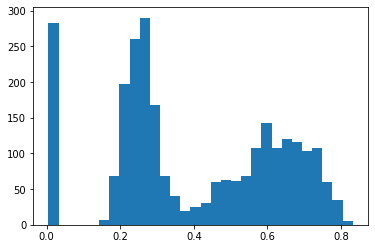

In [2106]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & ((preds_df3['t2']!=preds_df3['t3']) | (preds_df3['t1']!=preds_df3['t2']))]['t1_cont'], bins=30)


### Plot Estimated Attribution vs. Actual Attribution

In [2107]:
preds_df3 = preds_df3[(preds_df3['t1']!=preds_df3['t2']) | (preds_df3['t1']!=preds_df3['t3'])] 
preds_df3 = preds_df3[(preds_df3['actual']==1)]

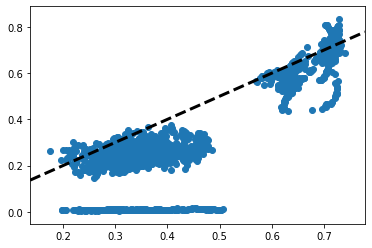

In [2108]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t1_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t1_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

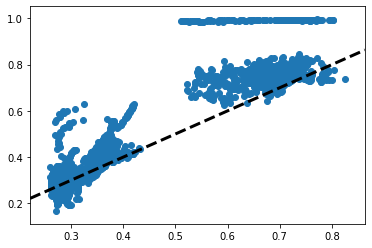

In [2109]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t2_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t2_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

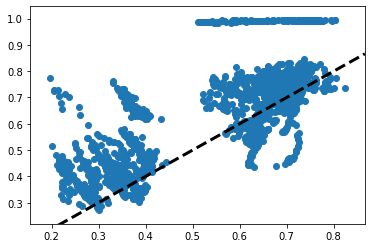

In [2110]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t3_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t3_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

### Calculate residuals for the DLAW model and 3 naive models: 50/50 split, last touched, and first touched

In [2111]:
#preds_df3['cont_error'] = ( abs(preds_df3['t1_cont']-preds_df3['t1_attn'])+abs(preds_df3['t2_cont']-preds_df3['t2_attn']) ) / (num_time_steps-1)
preds_df3['cont_error'] = ( abs(preds_df3['t1_cont']-preds_df3['t1_attn'])+abs(preds_df3['t2_cont']-preds_df3['t2_attn'])+abs(preds_df3['t3_cont']-preds_df3['t3_attn']) ) / num_time_steps
preds_df3['5050_cont_error'] = (abs(preds_df3['t1_cont']-(1/num_time_steps)) + abs(preds_df3['t2_cont']-(1/num_time_steps)) +abs(preds_df3['t3_cont']-(1/num_time_steps)) ) / num_time_steps
preds_df3['last_touch_cont_error'] = 1-preds_df3['t3_cont']
preds_df3['first_touch_cont_error'] = 1-preds_df3['t1_cont']
#preds_df3 = preds_df3[preds_df3['t1']!=preds_df3['t2']]

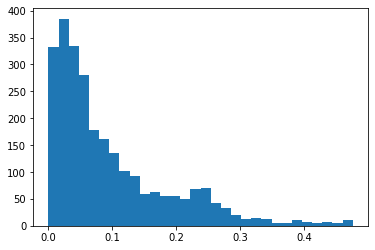

In [2112]:
_=plt.hist(preds_df3['cont_error'], bins=30)

(array([114., 349., 124.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <a list of 3 Patch objects>)

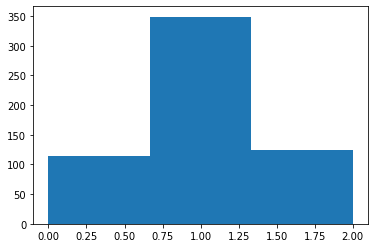

In [2113]:
lg_err = preds_df3[np.sqrt(preds_df3['cont_error']**2)>.15]
sm_err = preds_df3[np.sqrt(preds_df3['cont_error']**2)<=.1]

plt.hist(lg_err['t3'], bins=3)

In [2114]:
lg_err.columns

Index(['index', 't1', 't2', 't3', 'gender', 'gap1', 'log_gap1', 'gender_t2',
       'gap2', 'log_gap2', 'gender_t3', 'gap3', 'log_gap3', 'epsilon',
       'pred_prob', 'actual', 'pred', 't1_attn_unscaled', 't2_attn_unscaled',
       't3_attn_unscaled', 'cont_fb', 'cont_gg', 'cont_sp', 't1_attn',
       't2_attn', 't3_attn', 't1_cont', 't2_cont', 't3_cont', 't23attn',
       'cont_error', '5050_cont_error', 'last_touch_cont_error',
       'first_touch_cont_error'],
      dtype='object')

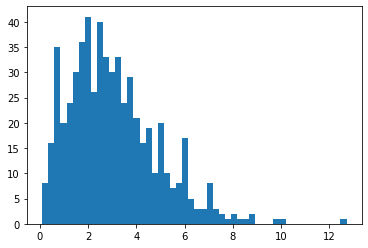

In [2115]:
_=plt.hist(lg_err['gap1'], bins=50)

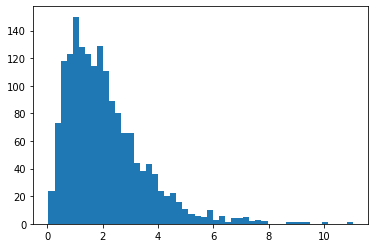

In [2116]:
_=plt.hist(sm_err['gap1'], bins=50)

### Calculate MAE only for observations with:
 - actual conversion==1: we only care about attributing people who converted
 - t1 channel does not equal t2 channel: there is no uncertainty of attribution in cases where t1 channel==t2 channel
 - predicted probability >0.03: These are likely noisier since the model found no signal for conversion. This was chosen arbitrarily ahead of time and does not change for each run

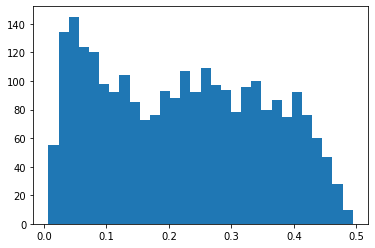

In [2117]:
_=plt.hist(preds_df3['pred_prob'], bins=30)

In [2118]:
min_p = .03

In [2119]:
len(preds_df3[preds_df3['pred_prob']>min_p])

2511

In [2120]:
len(preds_df3)

2615

### Predicted prob and the DLAW error is strongly negatively correlated indicating more certainty with higher predictions of conversion.

In [2121]:
print('Corr between predicted prob and magnitude of DLAW error:', round(np.corrcoef(preds_df3['pred_prob'], preds_df3['cont_error'])[0][1], 4))
print('Corr between predicted magnitude of t1_attn and magnitude of DLAW error:', round(np.corrcoef(preds_df3['t1_attn'], preds_df3['cont_error'])[0][1], 4))


Corr between predicted prob and magnitude of DLAW error: -0.5393
Corr between predicted magnitude of t1_attn and magnitude of DLAW error: -0.0853


In [2122]:
dlaw_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).mean()
dlaw_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).median()
dlaw_err_sd = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).std()
dlaw_95CI = dlaw_mae+(1.64*dlaw_err_sd)

even_split_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).mean()
even_split_medae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).median()
even_split_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).std()
even_split_95CI = even_split_mae+(1.64*even_split_err_sd)


lt_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).mean()
lt_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).median()
lt_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).std()
lt_95CI = lt_mae+(1.64*lt_err_sd)


ft_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).mean()
ft_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).median()
ft_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).std()
ft_95CI = ft_mae+(1.64*ft_err_sd)




print('DLAW Stats:\n', 'Mean AE:', round(dlaw_mae, 3), ', Median AE', round(dlaw_medae, 3), '95% CI Error:', round(dlaw_95CI, 3))
print('\n50/50 Split Stats:\n', 'Mean AE:', round(even_split_mae, 3), ', Median AE', round(even_split_medae, 3), '95% CI Error:', round(even_split_95CI, 3))
print('\nLast Touched Stats:\n', 'Mean AE:', round(lt_mae, 3), ', Median AE', round(lt_medae, 3), '95% CI Error:', round(lt_95CI, 3))
print('\nFirst Touched Stats:\n', 'Mean AE:', round(ft_mae, 3), ', Median AE', round(ft_medae, 3), '95% CI Error:', round(ft_95CI, 3))




DLAW Stats:
 Mean AE: 0.09 , Median AE 0.059 95% CI Error: 0.233

50/50 Split Stats:
 Mean AE: 0.228 , Median AE 0.216 95% CI Error: 0.425

Last Touched Stats:
 Mean AE: 0.405 , Median AE 0.4 95% CI Error: 0.71

First Touched Stats:
 Mean AE: 0.598 , Median AE 0.681 95% CI Error: 0.975


In [2132]:
preds_df3.columns

Index(['index', 't1', 't2', 't3', 'gender', 'gap1', 'log_gap1', 'gender_t2',
       'gap2', 'log_gap2', 'gender_t3', 'gap3', 'log_gap3', 'epsilon',
       'pred_prob', 'actual', 'pred', 't1_attn_unscaled', 't2_attn_unscaled',
       't3_attn_unscaled', 'cont_fb', 'cont_gg', 'cont_sp', 't1_attn',
       't2_attn', 't3_attn', 't1_cont', 't2_cont', 't3_cont', 't23attn',
       'cont_error', '5050_cont_error', 'last_touch_cont_error',
       'first_touch_cont_error'],
      dtype='object')

0.23823006161150342

7.856557538321596e-06

#### DLAW Distribution of Residuals

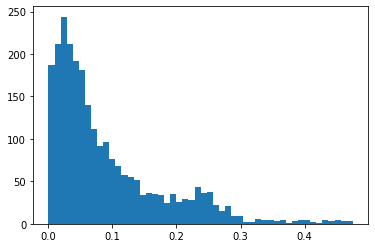

In [2124]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['cont_error'], bins=50)


In [ ]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['cont_error'], bins=50)


#### 50/50 Split Distribution of Residuals

In [ ]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'], bins=50)


#### Last Touched Distribution of Residuals

In [ ]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'], bins=50)


#### First Touched Distribution of Residuals

In [ ]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'], bins=50)


## Impact of Noise on the Model

### Distribution of error in False Positives is left skewed as expected. 
##### The model made the right inference of "Likely Conversion" based solely on the inputs available to it onaverage,but was screwed from the get go due to the large, negative error that ended up with the majority of impact in determining the actual conversion status

In [ ]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['epsilon'], bins=30)

### Distribution of error in True Positives is more symmetrical and centered closer to zero


In [ ]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==True)]['epsilon'], bins=30)

### Distribution of error in False Negatives is right skewed as expected


In [ ]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['epsilon'], bins=30)

### Distribution of error in True Negatives is more symmetrical and centered closer to zero


In [ ]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==False)]['epsilon'], bins=30)

### In the cases of False Positive and False Negative: the model made the right inference of "Likely Conversion" or "Unlikely Conversion", respectively, based solely on the inputs available to it on average.
### However it was screwed from the get go due to the large, negative or positive error, respectively, that ended up with the majority of impact in determining the actual conversion status

# Accuracy of Y Prediction
### *This is secondary to the main purpose of the model which is to learn attribution percentages, and is mostly unimportant given the simplicity of the DGP in the simulation. However, a model with better performance is more likely to specify the parameters correctly so improving the prediction accuracy can be expected to improve attribution accuracy as well.

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [401]:
conf = confusion_matrix(preds_df2['actual'], preds_df2['pred'])
conf = pd.DataFrame(conf)
conf.rename(columns={0:'pred_False', 1:'pred_True'}, inplace=True)
print('Test Accuracy:', accuracy_score(preds_df2['actual'], preds_df2['pred']))
print('Test Precision:', precision_score(preds_df2['actual'], preds_df2['pred']))
print('Test Recall:', recall_score(preds_df2['actual'], preds_df2['pred']))
conf

Test Accuracy: 0.8860333333333333


,pred_False,pred_True
0,25287,1702
1,1717,1294


## Error Distributions Correlations with Features

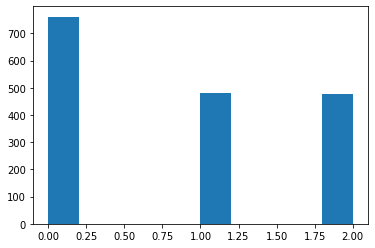

In [402]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t2'])

### False positives appear to be worse for Google (1) in T1 and Facebook (0) in T2

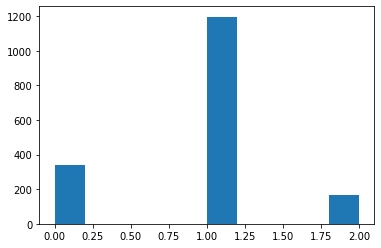

In [403]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['t1'])

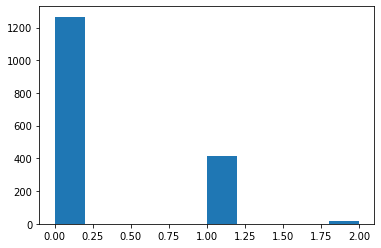

In [404]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['t2'])

### False Negatives appear to be worse for Facebook (0) in T2

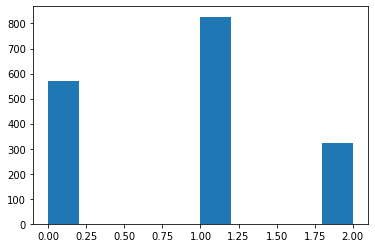

In [405]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t1'])

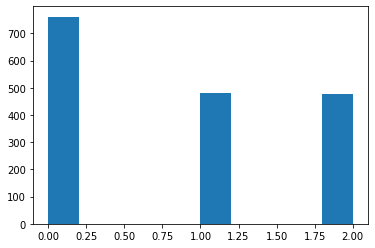

In [406]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t2'])

### Elapsed time (gap1) distribution for False Negative

In [ ]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['gap1'])

### Elapsed time (gap1) distribution for False Positive

In [ ]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['gap1'])
